### Change file name

In [1]:
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import sys
import os

# fix problem with local packages
cur_dir = os.getcwd()
sys.path.append(os.path.dirname(cur_dir))

root_dir = '/media/deep/Transcend/sar-rarp-dataset/traindata/video_test_1.zip/'
seg_dir = 'segmentation/'
rgb_dir = 'rgb/'

# for f_name in glob.glob(root_dir + seg_dir + 'traindata*.png'):
#     img = plt.imread(f_name)
#     new_name = f_name.split('_')[-1]
#     plt.imsave(root_dir + seg_dir + new_name, img)


### View data with seg mask

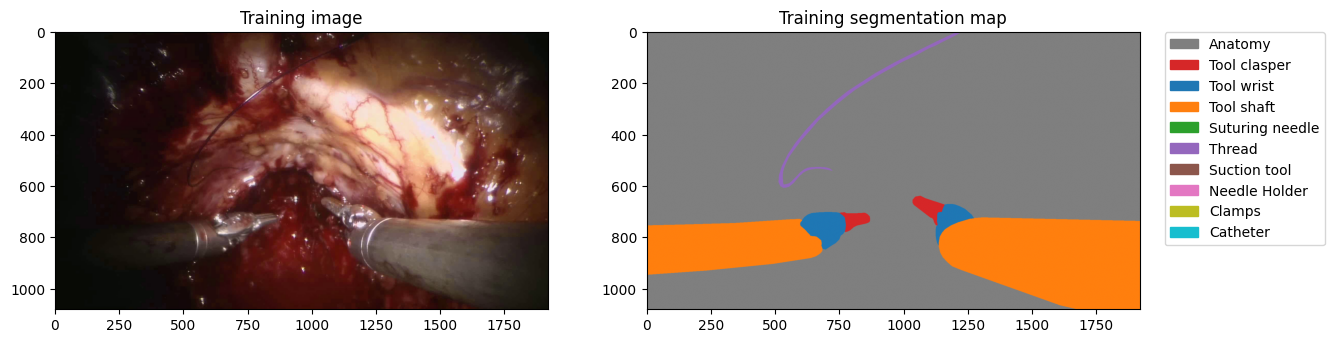

In [2]:
f_name_list = []
for seg_name in glob.glob(root_dir + seg_dir + '*.png'):
    rgb_name = glob.glob(root_dir + rgb_dir + seg_name.split('/')[-1])[0]
    f_name_list.append([rgb_name, seg_name])

colors = ['tab:gray', 'tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
palette_dict = {i: mpl.colors.to_rgb(c) for i, c in enumerate(colors)}
classes = ("Anatomy", "Tool clasper", "Tool wrist", "Tool shaft", "Suturing needle", "Thread", "Suction tool", "Needle Holder", "Clamps", "Catheter")

idx = 0
plt.figure(figsize=(14,20))
plt.subplot(121)
img_rgb = plt.imread(f_name_list[idx][0])
plt.imshow(img_rgb)
plt.title("Training image")

plt.subplot(122)
img_seg = Image.open(f_name_list[idx][1])
img_seg = np.array(img_seg.convert('RGB'), dtype=float)
for i in range(img_seg.shape[0]):
    for j in range(img_seg.shape[1]):
        img_seg[i,j,:] = palette_dict[img_seg[i,j,0]]

patches = [mpatches.Patch(color=colors[i], label=cls) for i, cls in enumerate(classes)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='medium')
plt.imshow(img_seg)
plt.title("Training segmentation map")
plt.show()


### View training

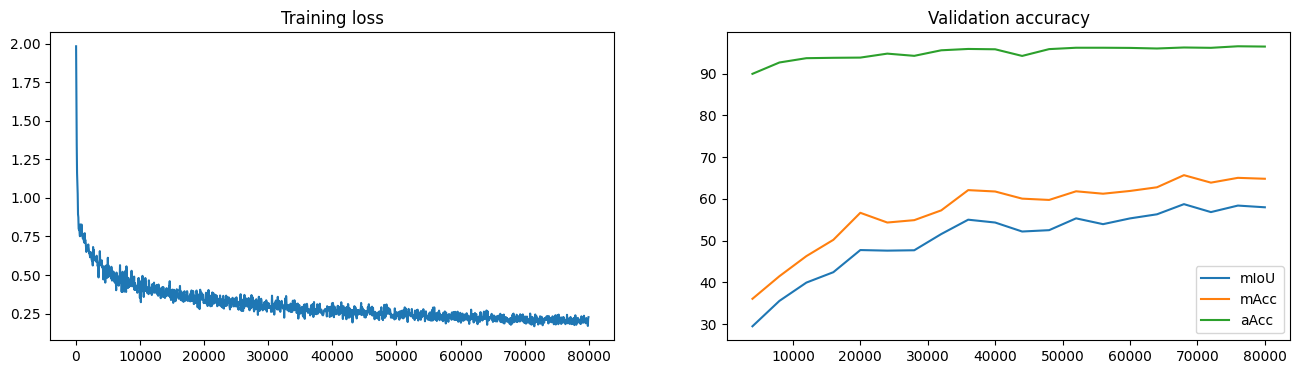

In [3]:
import json

train_iter, train_lr, train_decode_acc, train_loss = [], [], [], []
val_iter, val_miou, val_macc, val_aacc  = [], [], [], []

f = open('./segformer.b1.512x512.rarp50.80k/20230503_132722.log.json', 'r')
lines = f.readlines()
lines.pop(0)
for line in lines:
    js = json.loads(line)
    if js["mode"] == "train":
        train_iter.append(js["iter"])
        train_lr.append(js["lr"])
        train_decode_acc.append(js["decode.acc_seg"])
        train_loss.append(js["loss"])
    elif js["mode"] == "val":
        val_iter.append(js["iter"])
        val_miou.append(js["mIoU"])
        val_macc.append(js["mAcc"])
        val_aacc.append(js["aAcc"])

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(train_iter, train_loss)
plt.title("Training loss")

plt.subplot(122)
plt.plot(val_iter, val_miou)
plt.plot(val_iter, val_macc)
plt.plot(val_iter, val_aacc)
plt.title("Validation accuracy")
plt.legend(["mIoU", "mAcc", "aAcc"])


Use load_from_local loader


/home/deep/DL_project/Segformer_RARP50/mmseg/models/segmentors/base.py:268: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


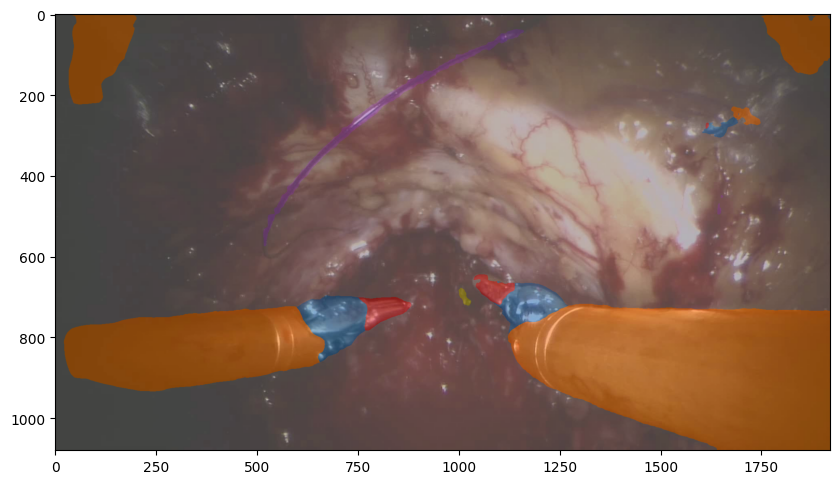

In [4]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

config_file = './segformer.b1.512x512.rarp50.80k/segformer.b1.512x512.rarp50.80k.py'
checkpoint_file = './segformer.b1.512x512.rarp50.80k/latest.pth'

model = init_segmentor(config_file, checkpoint_file, device='cuda:0')
img_dir = f_name_list[idx][0]
result = inference_segmentor(model, img_dir)
palette = np.array([mpl.colors.to_rgb(c) for c in colors])*255

show_result_pyplot(model, img_dir, result, palette.astype(int), (10,6))


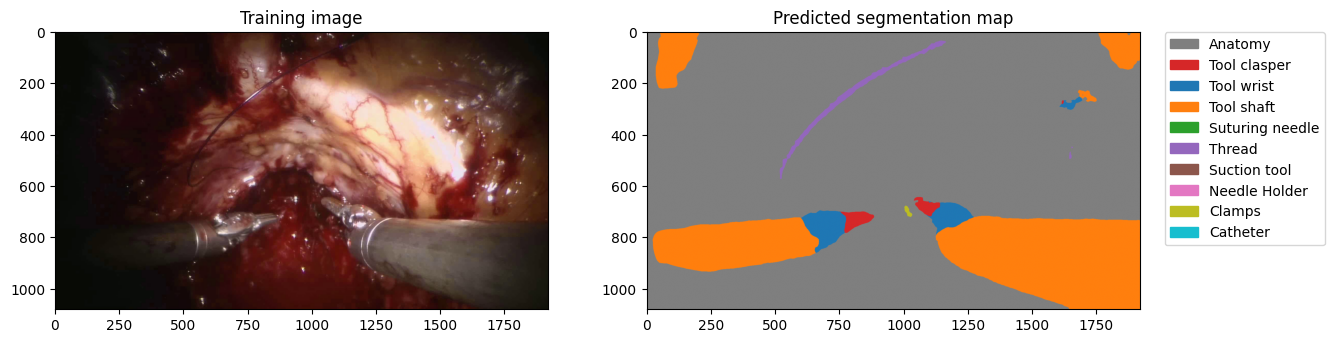

In [5]:
plt.figure(figsize=(14,20))
plt.subplot(121)
img_rgb = plt.imread(f_name_list[idx][0])
plt.imshow(img_rgb)
plt.title("Training image")

plt.subplot(122)
img_seg = np.zeros(img_rgb.shape, dtype=float)
for i in range(img_seg.shape[0]):
    for j in range(img_seg.shape[1]):
        img_seg[i,j,:] = palette_dict[result[0][i,j]]

patches = [mpatches.Patch(color=colors[i], label=cls) for i, cls in enumerate(classes)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='medium')
plt.imshow(img_seg)
plt.title("Predicted segmentation map")
plt.show()